In [ ]:
#!pip install geopy

In [14]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
from pandas import json_normalize
import numpy as np
import os
import csv
import multiprocessing as mp
import re
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib
import geopy
import sys
sys.path.append("..")
from math import sqrt


import warnings
warnings.filterwarnings("ignore")


In [3]:
article_df = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
article_df

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
0,TOI,2010-01-01,http://timesofindia.indiatimes.com//city/mumbai/Mumbai-celebrates-a-cool-New-Years-Eve-at-13-4C/...,Mumbai celebrates a cool New Year's Eve at 13.4फ्C,MUMBAI: The city witnessed its lowest temperature of the season on New Year ’s Eve when the merc...,"TNN / Jan 1, 2010, 01:47 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,mumbai,2010.0,maharashtra,mumbai suburban,{'smog': 3.0}
1,TOI,2010-01-02,http://timesofindia.indiatimes.com//city/lucknow/Dense-fog-leads-to-tripping-of-power-lines/arti...,Dense fog leads to tripping of power lines,LUCKNOW: The UP Power Corporation Limited is keeping its fingers crossed for Saturday with the s...,"TNN / Jan 2, 2010, 06:40 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,lucknow,2010.0,uttar pradesh,lucknow,{'air pollutants': 2.0}
2,TOI,2010-01-09,http://timesofindia.indiatimes.com//city/chennai/City-has-high-levels-of-smog-forming-ozone/arti...,City has high levels of smog-forming ozone,CHENNAI: Dangerous levels of ground-level ozone that causes respiratory ailments could be envelo...,"Bhama Devi Ravi / TNN / Jan 9, 2010, 00:37 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'ozone': 9.0, 'smog': 4.0}"
3,TOI,2010-01-11,http://timesofindia.indiatimes.com//city/jaipur/Woman-four-kids-in-hospital-after-inhaling-smoke...,"Woman, four kids in hospital after inhaling smoke",JAIPUR: A woman and her four kids were admitted to a city hospital in a serious condition after ...,"TNN / Jan 11, 2010, 01:56 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,jaipur,2010.0,rajasthan,jaipur,{'carbon monoxide': 1.0}
4,TOI,2010-01-13,http://timesofindia.indiatimes.com//city/chennai/Pollution-high-on-Bhogi-eve-Study/articleshow/5...,Pollution high on Bhogi eve: Study,"CHENNAI: By the time you get to read this, the Bhogi pollutants may have enveloped the city, but...","Bhama Devi Ravi / TNN / Jan 13, 2010, 04:23 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'air quality': 1.0, 'carbon monoxide': 1.0, 'ozone': 1.0, 'so2': 1.0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,Hindu,2021-05-16,https://www.thehindu.com/news/national/andhra-pradesh/naval-dockyard-teams-repair-two-oxygen-pla...,Naval Dockyard teams repair two oxygen plants in Nellore and Srikalahasti,Oxygen supply gets a big boost with this in the State during the pandemic\n\nTeams from the Nava...,SpecialCorrespondent,https://www.thehindu.com/news/national/andhra-pradesh/fvjzld/article34572702.ece/ALTERNATES/LAND...,andhra pradesh,visakhapatnam,NaN,andhra pradesh,visakhapatnam,{'carbon monoxide': 2.0}
17370,Hindu,2021-05-24,https://www.thehindu.com/news/national/kerala/greens-call-for-a-relook-into-silverline-implement...,Greens call for a relook into SilverLine implementation,"The Kerala Paristhithi Aikya Vedi, a forum of environmentalists, has urged Chief Minister Pinara...",SpecialCorrespondent,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,kerala,thiruvananthapuram,NaN,kerala,thiruvananthapuram,{'air pollution': 1.0}
17371,Hindu,2021-05-25,https://www.thehindu.com/news/national/karnataka/cftris-ozone-based-air-disinfection-system-to-c...,CFTRI’s ozone-based air disinfection system to combat droplet infections,The CSIR-Central Food Technological Research Institute (CFTRI) in Mysuru has come up with an ozo...,LaiqhAKhan,https://www.thehindu.com/sci-tech/science/wsmdd0/article33283019.ece/ALTERNATES/LANDSCAPE_615/CF...,karnataka,mysuru,NaN,karnataka,mysuru,{'ozone': 9.0}
17372,Hindu,2021-05-28,https://www.thehindu

### Load shape file for India

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from shapely.geometry import Polygon, mapping

#latest data , new districts e.x. arvalli, chhota udaipur
#gdf = gpd.read_file("choropleth_plot/india/kaggle/output.shp")

#according to 2011 which matches with sarath data
gdf = gpd.read_file("India_shapefiles_2011/2011_Dist.shp")
gdf.rename(columns = {"DISTRICT":"distname",
                      "ST_NM":"statename"},inplace=True)

gdf.distname = gdf.distname.apply(lambda x:x.strip().lower())
#gdf.replace("ahmadabad","ahmedabad",inplace=True)
gdf_districts_geometry = gdf[["statename","distname","geometry"]]

#to do manual stuff for new data
# gdf_districts_geometry.replace({"haora":"howrah",
#                                "west jaintia hills":"jaintia hills",
#                                "east jaintia hills":"jaintia hills",
#                                "aravali":"Sabar Kantha",
#                                "chhota udaipur":"Vadodara",},inplace=True)
gdf_districts_geometry

,statename,distname,geometry
0,Andhra Pradesh,adilabad,"POLYGON ((78.84972 19.76010, 78.85102 19.75945, 78.85898 19.73914, 78.86233 19.73246, 78.86282 1..."
1,Uttar Pradesh,agra,"POLYGON ((78.19803 27.40280, 78.19804 27.40278, 78.20894 27.40161, 78.21716 27.40071, 78.22324 2..."
2,Gujarat,ahmadabad,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23.49531, 72.03045 23.48499, 72.02583 23.47749, 72.0..."
3,Maharashtra,ahmadnagar,"POLYGON ((74.67333 19.94670, 74.67393 19.93509, 74.68202 19.93222, 74.68195 19.92493, 74.65599 1..."
4,Mizoram,aizawl,"POLYGON ((92.98749 24.40453, 92.99107 24.40236, 92.99451 24.39882, 92.99720 24.39843, 92.99965 2..."
...,...,...,...
636,Gujarat,tapi,"POLYGON ((74.08573 21.55513, 74.08672 21.55515, 74.08771 21.55519, 74.08871 21.55524, 74.08971 2..."
637,Andaman & Nicobar Island,nicobar,"MULTIPOLYGON (((93.84861 7.24051, 93.84870 7.23967, 93.84869 7.23808, 93.84853 7.23691, 93.84852..."
638,Andaman & Nicobar Island,south andaman,"MULTIPOLYGON (((92.69758 12.23961, 92.69778 12.23946, 92.69811 12.23949, 92.69843 12.23961, 92.6..."
639,Andaman & Nicobar Island,north & middle andaman,"MULTIPOLYGON (((92.89905 12.91512, 92.89905 12.91459, 92.89942 12.91456, 92.89948 12.91459, 92.8..."


### Load pollution data districtwise

In [5]:
df_district_pm25 = pd.read_excel("Satellite-Derived-District-Concentrations.xlsx")
year = 2016
df_district_pm25 = df_district_pm25[["dist_name","state_name",f"Y{year}"]]
df_district_pm25.rename(columns={"dist_name":"distname",f"Y{year}":"PM2_5","state_name":"statename"},inplace=True)
df_district_pm25.distname = df_district_pm25.distname.apply(lambda x:x.strip().lower())
df_district_pm25["PM2_5"] = df_district_pm25["PM2_5"].apply(lambda x: 25 if pd.isna(x) else x).values
df_district_pm25


,distname,statename,PM2_5
0,anantnag,Jammu & Kashmir,36.493781
1,badgam,Jammu & Kashmir,44.983151
2,bandipore,Jammu & Kashmir,33.338533
3,baramula,Jammu & Kashmir,43.573255
4,doda,Jammu & Kashmir,39.079964
...,...,...,...
636,yanam,Puducherry,34.790145
637,nicobar,Andaman & Nicobar Island,8.266474
638,north & middle andaman,Andaman & Nicobar Island,15.403841
639,south andaman,Andaman & Nicobar Island,13.820844


### Merge shape df & pollution level df

In [6]:
df_inner = df_district_pm25.merge(gdf_districts_geometry,left_on=["distname","statename"],right_on=["distname","statename"],how="inner")
#df_inner["PM2_5"] = df_inner["PM2_5"].apply(lambda x: 25 if pd.isna(x) else x).values
df_inner

,distname,statename,PM2_5,geometry
0,anantnag,Jammu & Kashmir,36.493781,"POLYGON ((75.63102 34.22268, 75.63737 34.22115, 75.65162 34.22464, 75.66996 34.22816, 75.68626 3..."
1,badgam,Jammu & Kashmir,44.983151,"POLYGON ((74.82323 34.04905, 74.82835 34.04648, 74.85075 34.04679, 74.87713 34.05223, 74.89146 3..."
2,bandipore,Jammu & Kashmir,33.338533,"POLYGON ((75.39242 34.54345, 75.39851 34.53122, 75.39466 34.51254, 75.39284 34.49556, 75.39538 3..."
3,baramula,Jammu & Kashmir,43.573255,"POLYGON ((74.71388 34.34671, 74.68943 34.34635, 74.67750 34.33091, 74.66572 34.30868, 74.67460 3..."
4,doda,Jammu & Kashmir,39.079964,"POLYGON ((75.54241 33.36069, 75.55790 33.33790, 75.58896 33.28959, 75.63273 33.24843, 75.62882 3..."
...,...,...,...,...
636,yanam,Puducherry,34.790145,"POLYGON ((82.22052 16.73898, 82.22431 16.73626, 82.22997 16.72939, 82.23659 16.72826, 82.25450 1..."
637,nicobar,Andaman & Nicobar Island,8.266474,"MULTIPOLYGON (((93.84861 7.24051, 93.84870 7.23967, 93.84869 7.23808, 93.84853 7.23691, 93.84852..."
638,north & middle andaman,Andaman & Nicobar Island,15.403841,"MULTIPOLYGON (((92.89905 12.91512, 92.89905 12.91459, 92.89942 12.91456, 92.89948 12.91459, 92.8..."
639,south andaman,Andaman & Nicobar Island,13.820844,"MULTIPOLYGON (((92.69758 12.23961, 92.69778 12.23946, 92.69811 12.23949, 92.69843 12.23961, 92.6..."


# PM2.5 vs Articles: districtwise choropleth map

In [10]:
df_articles =  pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")

# df_articles[df_articles["city"].apply(lambda x:type(x)==list)]
gdf_districts_geometry[gdf_districts_geometry.statename == "NCT of Delhi"]

df_articles_districtwise = df_articles[~pd.isna(df_articles.district)].groupby("district").count()["url"].reset_index().sort_values("url",ascending=False)
df_articles_districtwise.rename(columns={"url":"count"},inplace=True)

#rename some districts to match with districts of shapefile
#beacuse district of cities comes from geopy library
#they may be mismatch with district names in shapefile of 2011

df_articles_districtwise.replace({"bangalore urban":"bangalore",
                     "central delhi":"delhi",
                     "darjeeling":'darjiling',
                     'fategarh sahib':'fatehgarh sahib',
                    'gurugram':'gurgaon',
                    'kalaburagi':'gulbarga',
                    'paschim bardhaman':'barddhaman',
                    'ahmedabad':'ahmadabad',
                    "jharkhand":"ranchi",
                    "mysuru":"mysore",
                    "prayagraj":"allahabad",
                    "howrah":"haora",
                    "ysr":"y.s.r.",
                    "virudhunagar":"virudunagar",
                                 },inplace=True)


df_articles_geometry_merged = gdf_districts_geometry.merge(df_articles_districtwise,left_on="distname",right_on="district",how="left")
df_not_na_district = df_articles_geometry_merged[~pd.isna(df_articles_geometry_merged["district"])]
print(f"{len(df_not_na_district)} districts have articles data")
#to manually enter articles of delhi
#df_articles_geometry_merged["count"] = df_articles_geometry_merged.apply(lambda x:5200 if x.statename == "NCT of Delhi" else x["count"],axis=1).values


n = 15

top_n = df_articles_geometry_merged.nlargest(n,"count")
top_n['coords'] = df_articles_geometry_merged['geometry'].apply(lambda x: x.representative_point().coords[:][0])
top_n.replace({"gautam buddha nagar":"noida","mumbai suburban":"mumbai","haora":"howrah"},inplace=True)
top_n


126 districts have articles data


,statename,distname,geometry,district,count,coords
212,Haryana,gurgaon,"POLYGON ((76.66657 28.37812, 76.67406 28.38000, 76.68225 28.37713, 76.69708 28.37018, 76.69862 2...",gurgaon,849.0,"(76.94237038360454, 28.368636998304794)"
382,Maharashtra,mumbai,"POLYGON ((72.95859 18.98734, 72.94677 18.98574, 72.91373 18.98226, 72.90092 18.97963, 72.89682 1...",mumbai,647.0,"(72.90043303438506, 19.124036019665493)"
106,Chandigarh,chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623, 76.83805 30.72696, 76.84759 30.72053, 76.84952 3...",chandigarh,623.0,"(76.78051175491176, 30.730184003362076)"
46,Karnataka,bangalore,"POLYGON ((77.83549 12.86809, 77.83213 12.86372, 77.83198 12.85895, 77.82693 12.85807, 77.82350 1...",bangalore,600.0,"(77.55306792001653, 12.943591455447502)"
110,Tamil Nadu,chennai,"POLYGON ((80.29769 13.12548, 80.29798 13.11914, 80.30015 13.11373, 80.30066 13.11078, 80.30074 1...",chennai,488.0,"(80.25040930538992, 13.066124327240331)"
218,West Bengal,howrah,"MULTIPOLYGON (((87.99513 22.77300, 87.99747 22.76516, 87.99861 22.75506, 88.00001 22.75025, 88.0...",howrah,488.0,"(88.03561374002868, 22.499492924654017)"
392,Maharashtra,nagpur,"POLYGON ((79.51189 21.58940, 79.51674 21.58231, 79.52780 21.57948, 79.53375 21.57397, 79.53823 2...",nagpur,471.0,"(79.01814778168442, 21.149349331211482)"
451,Maharashtra,pune,"POLYGON ((74.83388 18.33920, 74.83266 18.32908, 74.83670 18.32072, 74.84378 18.30964, 74.84634 1...",pune,396.0,"(73.92146100319253, 18.642540522215054)"
231,Andhra Pradesh,hyderabad,"POLYGON ((78.51164 17.45434, 78.51589 17.45266, 78.52469 17.45779, 78.53331 17.46361, 78.54018 1...",hyderabad,386.0,"(78.45656472067034, 17.38931282146857)"
195,Uttar Pradesh,noida,"POLYGON ((77.69833 28.27996, 77.69650 28.27841, 77.67803 28.26443, 77.68005 28.25988, 77.68271 2...",noida,368.0,"(77.58387131310607, 28.382137368875576)"


In [11]:
def get_point_of_dist(distname,article = None):
    temp = gdf_districts_geometry[gdf_districts_geometry["distname"] == distname]
    point = temp["geometry"].representative_point().values[0].coords[0]
    if distname =="central":
        return (point,5300)
    else:
        if article:
            return (point,article)
            
        else:
            articles = top_n[top_n["distname"] == distname]["count"].values[0]
            return (point,articles)

def draw_arrow_and_annotate(dist,dx,dy,ax,label=None,article=None):

    #arow
    del_point,articles = get_point_of_dist(dist,article)
    ax.arrow(del_point[0],del_point[1],dx,dy,color="gray",linewidth=0.3)

    #annotation
    sign_x, sign_y = np.sign(dx), np.sign(dy)
    text_point = (del_point[0]+dx+0.5*sign_x,del_point[1]+dy+0.5*sign_y)
    if label:
        ax.annotate(s= label, xy = text_point,horizontalalignment='center',rotation="0")
    else:
        ax.annotate(s=f"{dist.capitalize()} ({int(articles)})", xy = text_point,horizontalalignment='center',rotation="0")
    
    
def draw_arrow_and_annotate_general(start,dx,dy,ax,label):
    del_point = start
    ax.arrow(del_point[0],del_point[1],dx,dy,color="gray",linewidth=0.3)

    #annotation
    sign_x, sign_y = np.sign(dx), np.sign(dy)
    text_point = (del_point[0]+dx+0.5*sign_x,del_point[1]+dy+0.5*sign_y)
    ax.annotate(s= label, xy = text_point,horizontalalignment='center',rotation="0")

def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

test


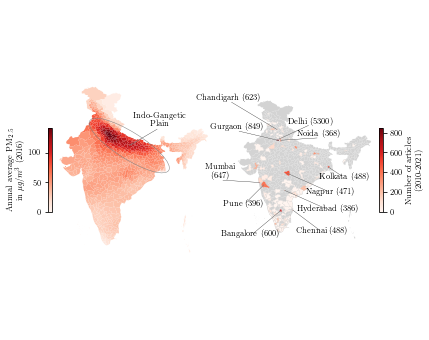

In [22]:
from matplotlib import patches
df_inner = df_district_pm25.merge(gdf_districts_geometry,left_on=["distname","statename"],right_on=["distname","statename"],how="inner")
#geo_df = df_articles_geometry_merged
vmin,vmax = 0,df_inner["PM2_5"].max()
latexify(columns=2,fig_width=6)
#karmify()
n_cols = len(df_inner.columns)
geo_df = gpd.GeoDataFrame(df_inner)
geo_df = geo_df.append(pd.DataFrame([[np.nan,np.nan,vmin,np.nan],[np.nan,np.nan,vmax,np.nan]],columns=geo_df.columns))


variable = "PM2_5"

fig, (ax1,ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.0)

# Create colorbar legend
cmap = "Reds"
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

cbar = fig.colorbar(sm,fraction=0.025,pad=0.0,ax=[ax1],location="left")

#cbar.ax.get_xaxis().labelpad = 15
cbar.set_label('Annual average PM$_{2.5}$\nin $\mu g/m^3$ (2016)',rotation=90, loc="center")
#axis-1
ax1.axis("off")
#geo_df.plot(ax=ax1, color="lightgray", edgecolor="lightgray", linewidth=0.4,rasterized=True)
geo_df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax1,label="PM2.5")

city_e = "lucknow"
x_e, y_e = gdf_districts_geometry[gdf_districts_geometry["distname"] == city_e]["geometry"].representative_point().values[0].coords[0]
x_e,y_e = x_e+1,y_e-0.5
h_e, w_e = 5,18
angle_e = 150
ellipse = patches.Ellipse(xy = (x_e,y_e),width = w_e,height = h_e,angle = angle_e,fill=False,linewidth=0.5,color="gray")
ax1.add_patch(ellipse)

#to draw arrow and annotate on map
draw_arrow_and_annotate_general((x_e,y_e),5.5,3,ax=ax1,label="Indo-Gangetic\nPlain")


#axis-2
geo_df = gpd.geopandas.GeoDataFrame(df_articles_geometry_merged)
variable = "count"

vmin,vmax = 0,geo_df[variable].max()
n_cols = len(geo_df.columns)


geo_df = geo_df.append(pd.DataFrame([[np.nan,np.nan,np.nan,np.nan,vmin],[np.nan,np.nan,np.nan,np.nan,vmax]],columns=geo_df.columns))

ax= ax2
ax.axis("off")
# Create colorbar legend
cmap = "Reds"
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure

# create map
geo_df.plot(color="lightgrey",ax=ax)
geo_df.plot(column=variable, cmap=cmap, linewidth=0.1, ax=ax, edgecolor='0.8',label="PM2.5")


#delhi 
# del_point,articles = get_point_of_dist("central")
# dx, dy = 4, 4
# ax.arrow(del_point[0],del_point[1],dx,dy,linewidth=1,linestyle="--")
# text_point = (del_point[0]+dx+0.5,del_point[1]+dy+0.5)
# ax.annotate(s="Delhi (5300)", xy = text_point,horizontalalignment='center',rotation="0")
taken = []

draw_arrow_and_annotate("central",6.5,3,ax=ax,label="Delhi (5300)")

taken.append("gurgaon")
draw_arrow_and_annotate(taken[-1],-8.5,2,ax)

taken.append("chandigarh")
draw_arrow_and_annotate(taken[-1],-10,6,ax)


taken.append("mumbai")
taken.append("mumbai suburban")
draw_arrow_and_annotate(taken[-1],-8,0.5,ax,article=647,label="Mumbai\n(647)")

taken.append("bangalore")
draw_arrow_and_annotate(taken[-1],-6,-5,ax,article=600)

taken.append("chennai")
draw_arrow_and_annotate(taken[-1],6,-4.5,ax)

taken.append("howrah")
taken.append("haora")
draw_arrow_and_annotate(taken[-1],3,-2,ax,label="Kolkata (488)",article=488)

taken.append("nagpur")
draw_arrow_and_annotate(taken[-1],9,-4,ax)

taken.append("pune")
draw_arrow_and_annotate(taken[-1],-4,-4,ax)

draw_arrow_and_annotate("hyderabad",9,-4,ax=ax)
draw_arrow_and_annotate("gautam buddha nagar",8,0.5,ax=ax,label="Noida (368)",article=368)

# taken.append("pune")
# draw_arrow_and_annotate(taken[-1],-4,0.01,ax)


#chennai
   
#proper place cities
# top_n_cpy = top_n[~top_n["distname"].isin(taken)].copy()
# for idx,row in top_n_cpy.iterrows():
#     x,y = row['coords'][0] ,row['coords'][1] + 0.4
#     plt.annotate(s=f"{row['distname'].capitalize()}({int(row['count'])})", xy= (x,y),horizontalalignment='center',rotation="0")

cbar = fig.colorbar(sm,fraction=0.025,pad=0.0,orientation="vertical",ax=ax2)
#cbar.ax.get_xaxis().labelpad = 15
#cbar.ax.set_xlabel('Number of articles (2010-2021)', rotation=90, xy=(1,0.5))
cbar.set_label('Number of articles\n(2010-2021)', rotation=90, loc="center")

plt.axis("equal")
#ax3.axis("off")
print("test")
plt.show()
#fig.savefig("plots/latex/img_two_choropleth_sidebyside_india.pdf",bbox_inches="tight")

In [20]:
fig.savefig("../figures/fig3_choropleth_map.pdf",bbox_inches="tight")